El objetivo es programar una función que reciba como input un texto de usuario y devuelva los fragmentos de texto (chunks) que hagan referencia a las comidas y cantidades que ha solicitado. No es necesario, ni es el objetivo de este ejercicio, construir un clasificador de intención previo a esta función, sino simplemente una función que presuponemos recibe una frase con la intención 'Pedir_comida'. Tampoco es objetivo normalizar la salida (por ej.: no es necesario convertir 'tres' a '3' ni 'pizzas' a 'pizza'). Es, por tanto, un ejercicio de mínimos.

el alumno deberá usar un NaiveBayesClassifier, en lugar del MaxEntClassifier, para localizar los elementos descritos anteriormente (comida y cantidad)

Se deberá comenzar la práctica por el nivel más básico de dificultad (RegexParser) y, en caso de conseguirlo, añadir los siguientes niveles de forma sucesiva. De esta forma, el entregable contendrá todas y cada una de las tres formas de solucionar el problema. No basta, por tanto, con incluir, por ejemplo, únicamente un NaiveBayesClassifier, hay que incluir también las otras dos formas si se quiere obtener la máxima puntuación.

Para llevar a cabo la práctica, deberá construirse una cadena NLP con NLTK, con los siguientes elementos:

    segmentación de frases,
    tokenización,
    POS tagger (analizador mofológico para el español).

A continuación, los POS tags obtenidos serán usados por el RegexParser, el UnigramParser, el BigramParser y el NaiveBayesClassifier.


In [1]:
# Creamos un corpus de ejemplo para el reconocimiento de peticiones de comida:
corpus_comida = ["Me gustaria tomar unas rabas",
                 "Quisiera un pincho de tortilla", 
                 "Me encantaria unas gambas a la plancha",
                 "Me pones un bocadillo de bacon con queso?",
                 "Podrias ponerme una ensalada de tomate?",
                 "Un bocata de lomo",
                 "Unos pimientos del piquillo",
                 "Me puedes traer un plato combinado?",
                 "Podria ser un filete poco hecho?"]

In [2]:
import datetime
import nltk
# Entrenamos el tagger
from nltk.corpus import cess_esp

from nltk import UnigramTagger, BigramTagger, TrigramTagger,DefaultTagger
from nltk.tag.hmm import HiddenMarkovModelTagger

# Procedemos al entrenamiento utilizando los tags de cess_esp
sents = cess_esp.tagged_sents()
#Metemos en el conjunto de entrenamiento el 90% de las frases, y el restante 10% en el conjunto de test
training = []
test = []
print("Generando sentencias de aprendizaje...", datetime.datetime.now())
for i in range(len(sents)):
    if i % 10:
        training.append(sents[i])
    else:
        test.append(sents[i])

# Establecemos la cadena de taggeo, utilizando el HMM en primer lugar y haciendo que,
# si no reconoce una palabra la intente taggear usando otro tagger y asi sucesivamente.
print("Entrenando al Tagger ...", datetime.datetime.now())
default_tagger = DefaultTagger ('NLTK_FASHION')
unigram_tagger = UnigramTagger(training, backoff=default_tagger)
bigram_tagger = BigramTagger(training, backoff=unigram_tagger)
trigram_tagger = TrigramTagger(training, backoff=bigram_tagger)
hmm_tagger = HiddenMarkovModelTagger.train(training, backoff=trigram_tagger)
print("Tagger entrenado...", datetime.datetime.now())

Generando sentencias de aprendizaje... 2018-08-31 23:27:42.891839
Entrenando al Tagger ... 2018-08-31 23:28:12.079350
Tagger entrenado... 2018-08-31 23:28:17.029585


In [49]:
# Una vez entrenado procedemos a analizar las frases de nuestro corpus mediante un 
# Regexp parser para obtener las entidades que aparezcan en los textos
# Definimos la gramatica que nos permita reconocer comidas y cantidades
# particionar comidas

# Definimos un tagger con RegExp:
patterns = [
    (r'(.[0-9]+|unas|una|un|unos)','CANT'),
    (r'bocadillo|bocata|pizza|piza|pincho|racion|plato', 'TipoCOMIDA'),
    (r'jamon|chorizo|queso|calamares|pimientos|patatas|tortilla','INGR')
]
regexp_tagger = nltk.RegexpTagger(patterns, backoff=bigram_tagger)
grammar = r"""
  Comida: {(<CANT> <TipoCOMIDA | INGR> )} # Comida
  ComidaElaborada: {(<Comida> <INGR>)}
  """
regex_parser = nltk.RegexpParser(grammar)

print(regex_parser)

chunk.RegexpParser with 2 stages:
RegexpChunkParser with 1 rules:
    Comida   <ChunkRule: '(<CANT> <TipoCOMIDA | INGR> )'>
RegexpChunkParser with 1 rules:
       <ChunkRule: '(<Comida> <INGR>)'>


[('Quiero', 'vmip1s0'), ('un', 'CANT'), ('jamon', 'INGR'), ('y', 'cc'), ('un', 'CANT'), ('plato', 'TipoCOMIDA'), ('calamares', 'INGR')]
# Input:
 <vmip1s0>  <CANT>  <INGR>  <cc>  <CANT>  <TipoCOMIDA>  <INGR> 
# Comida:
 <vmip1s0> {<CANT>  <INGR>} <cc> {<CANT>  <TipoCOMIDA>} <INGR> 
# Input:
 <vmip1s0>  <Comida>  <cc>  <Comida>  <INGR> 
# :
 <vmip1s0>  <Comida>  <cc> {<Comida>  <INGR>}


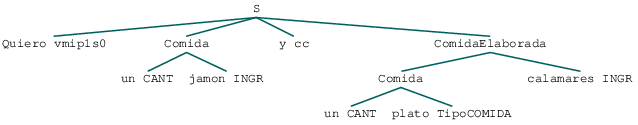

In [50]:
from nltk import Tree
from nltk.chunk import *

sentencia = "Quiero un jamon y un plato calamares"
tokens = nltk.word_tokenize(sentencia)
# tagged = hmm_tagger.tag(tokens)
# print ("TAGGER HMMs:",tagged)
# tagged_bigram = bigram_tagger.tag(tokens)
# print ("TAGGER Bigram:",tagged_bigram)
# prueba = nltk.pos_tag(tokens)
# print(prueba)
# chunked_text = tagstr2tree('quiero/OT un/Cantidad jamon/Comida')
# print (chunked_text)
# PROBANDO!!!!
taggeado = regexp_tagger.tag(tokens)
print(taggeado)
regex_parser.parse(taggeado, trace = True)